# 細胞核影像分割

# Segmentation models

安裝 segmentation_models library  以使用 pre-trained model 進行 Transfer Learning

https://github.com/qubvel/segmentation_models

In [ ]:
!pip install -U -q segmentation-models

     |████████████████████████████████| 50 kB 6.8 MB/s 


Import 需要的 library，並且將 environment variable 設置為 `tf.keras`

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
import os 
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


# 資料集讀取

In [ ]:
!unzip nuclei_data.zip

Archive:  nuclei_data.zip
   creating: nuclei_data/
   creating: nuclei_data/images/
  inflating: nuclei_data/images/img0000.png  
  inflating: nuclei_data/images/img0001.png  
  inflating: nuclei_data/images/img0002.png  
  inflating: nuclei_data/images/img0003.png  
  inflating: nuclei_data/images/img0004.png  
  inflating: nuclei_data/images/img0005.png  
  inflating: nuclei_data/images/img0006.png  
  inflating: nuclei_data/images/img0007.png  
  inflating: nuclei_data/images/img0008.png  
  inflating: nuclei_data/images/img0009.png  
  inflating: nuclei_data/images/img0010.png  
  inflating: nuclei_data/images/img0011.png  
  inflating: nuclei_data/images/img0012.png  
  inflating: nuclei_data/images/img0013.png  
  inflating: nuclei_data/images/img0014.png  
  inflating: nuclei_data/images/img0015.png  
  inflating: nuclei_data/images/img0016.png  
  inflating: nuclei_data/images/img0017.png  
  inflating: nuclei_data/images/img0018.png  
  inflating: nuclei_data/images/img0019.p

In [ ]:
def get_data_list(data_path):
    data_list = []
    for i in os.listdir(data_path):
        if i.endswith('.png'):
            img_path = os.path.join(data_path, i)
            data_list.append(img_path)
        
    data_list.sort()
    return data_list

In [ ]:
train_val_imgs = get_data_list('nuclei_data/images')
train_val_masks = get_data_list('nuclei_data/labels')
test_imgs = get_data_list('nuclei_data/test_images')
test_masks = get_data_list('nuclei_data/test_labels')

print('Total number of training and validation image data:', len(train_val_imgs))
print('Total number of training and validation mask data:', len(train_val_masks))
print('Total number of test image data:', len(test_imgs))
print('Total number of test mask data:', len(test_masks))

Total number of training and validation image data: 590
Total number of training and validation mask data: 590
Total number of test image data: 10
Total number of test mask data: 10


## 觀察資料

In [ ]:
# _, axes = plt.subplots(1, 2, figsize=(8, 4))
# axes[0].set_title('Image')
# img = cv2.imread(train_val_imgs[0])
# axes[0].imshow(img)

# mask = cv2.imread(train_val_masks[0]).squeeze()
# axes[1].set_title('Mask')
# axes[1].imshow(mask, cmap='gray')

In [ ]:
# _, axes = plt.subplots(1, 2, figsize=(8, 4))
# axes[0].set_title('Image')
# img = cv2.imread(train_val_imgs[2])
# axes[0].imshow(img)

# mask = cv2.imread(train_val_masks[2]).squeeze()
# axes[1].set_title('Mask')
# axes[1].imshow(mask, cmap='gray')

# 資料集劃分

通常會將資料集劃分為訓練集 (training set)、驗證集 (validation set)、測試集 (test set)


*   訓練集 (training set)：用於訓練模型參數
*   驗證集 (validation set)：用於檢驗模型的訓練狀況，作為調整超參數的依據
*   測試集 (test set)：評估模型的表現結果


In [ ]:
train_imgs, val_imgs, train_masks, val_masks = train_test_split(train_val_imgs, train_val_masks, test_size=0.1, random_state=42)

In [ ]:
print('Total number of training image data:', len(train_imgs))
print('Total number of traing mask data:', len(train_masks))
print('Total number of validation image data:', len(val_imgs))
print('Total number of validation mask data:', len(val_masks))
print('Total number of test image data:', len(test_imgs))
print('Total number of test mask data:', len(test_masks))

Total number of training image data: 531
Total number of traing mask data: 531
Total number of validation image data: 59
Total number of validation mask data: 59
Total number of test image data: 10
Total number of test mask data: 10


# 資料前處理 Data Preprocessing

在訓練模型前，需要先對資料進行前處理，將資料調整為適合模型輸入的格式。


In [ ]:
# _, axes = plt.subplots(1, 2, figsize=(8, 4))
# axes[0].set_title('Original image')
# org_img = cv2.imread(train_val_imgs[2])
# axes[0].imshow(org_img)

# img = cv2.imread(train_val_imgs[2])
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
# axes[1].set_title('Processed image')
# axes[1].imshow(img)

# print('Original image shape:', org_img.shape)
# print('Processed image shape:', img.shape)

In [ ]:
def load_img(data_list, img_size):
    data_img = []
    for i in data_list:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.
        data_img.append(img)

    data_img = np.array(data_img)
    return data_img

def load_mask(mask_list, img_size):
    data_mask = []
    for i in mask_list:
        mask = cv2.imread(i, 0)
        mask = cv2.resize(mask, (img_size, img_size))
        mask = mask / 255.                
        data_mask.append(mask)
        
    data_mask = np.array(data_mask)
    data_mask = np.expand_dims(data_mask, -1)
    return data_mask

In [ ]:
img_size = 256
train_x = load_img(train_imgs, img_size)
train_y = load_mask(train_masks, img_size)

val_x = load_img(val_imgs, img_size)
val_y = load_mask(val_masks, img_size)

test_x = load_img(test_imgs, img_size)
test_y = load_mask(test_masks, img_size)

print("Shape of train_x: ", train_x.shape)
print("Shape of train_y: ", train_y.shape)
print("Shape of val_x: ", val_x.shape)
print("Shape of val_y: ", val_y.shape)
print("Shape of test_x: ", test_x.shape)
print("Shape of test_y: ", test_y.shape)

Shape of train_x:  (531, 256, 256, 3)
Shape of train_y:  (531, 256, 256, 1)
Shape of val_x:  (59, 256, 256, 3)
Shape of val_y:  (59, 256, 256, 1)
Shape of test_x:  (10, 256, 256, 3)
Shape of test_y:  (10, 256, 256, 1)


# 資料增強 Data Augmentation

資料增強是一種通過現有資料來擴增原有資料的方式，藉由生成更多資料以防止模型過擬合 (over-fitting) ，並提升模型準確率。

所有要使用的 Data Augmentation 方法都可以寫在字典裡，再經過 ImageDataGenerator 實現。

這邊使用 `.flow(x,y)` 運用在訓練資料上，也可以直接運用在資料夾上 (`.flow_from_directory(directory)`)，使用方式可參考: [tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

另外，`.flow(x,y)` 運用在訓練圖像 (train_image) 和標籤 (train_mask) 裡都要需要設定相同的 seed 值，兩者的資料生成方式才會對應到。

tensorflow 提供了許多種的方法，可參考：[tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug_dict = dict(rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
        )

datagen  = ImageDataGenerator(**aug_dict)

In [ ]:
batch_size = 32
image_generator = datagen.flow(train_x, batch_size=batch_size, seed=1)
mask_datagen = datagen.flow(train_y, batch_size=batch_size, seed=1)
train_combined_generator = (pair for pair in zip(image_generator, mask_datagen))

# 模型建立及編譯

這邊模型使用 segmentation_models 提供的 U-Net 作為 pre-trained model，並且實例化模型後，要將其進行編譯，模型編譯的參數主要有優化器 (optimizer)、損失函數 (loss)、指標 (metric)。

這邊 loss function 使用 segmentation_models 提供的 dice_loss，metric 使用 iou_score。

segmentation_models 也可以提供其他的 model、loss function、metric：

*   model：[models](https://github.com/qubvel/segmentation_models/tree/master/segmentation_models/models)

*   loss function：[losses.py](https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/losses.py)
*   metric：[metrics.py](https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/metrics.py)
 

In [ ]:
model = sm.Unet(backend='resnet18', 
        encoder_weights='imagenet',
        activation="sigmoid",
        classes=1,
        input_shape=(256, 256, 3))

model.compile(optimizer = Adam(lr = 1e-3), loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score])

58889256/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

# Callback

Callback 應用於訓練階段，若達到設定的條件便會觸發調用 Callback 操作，能夠監控及察看模型的訓練過程。

以下使用幾種 Callback 方法:

* ModelCheckpoint：在訓練過程中，將模型進行儲存

* EarlyStopping：監控是否需要提早結束訓練

* ReduceLROnPlateau：當模型的訓練狀態無法再更好時，降低學習率 (learning rate)

除此之外，tensorflow 還提供了許多種的 Callback，可參考：[Module: tf.keras.callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks)


In [ ]:
model_dir = 'model_saved_transfer_learning'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
modelfiles = os.path.join(model_dir, 'best_model.h5')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles, monitor='val_loss', save_best_only=True, mode='auto')

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.1,
                    patience=5,
                    mode='auto',
                    min_delta=0.0001,
                    cooldown=0,
                    min_lr=0)

callbacks_list = [model_mckp, earlystop, reduce_lr]

# 模型訓練

使用 `model.fit()` 進行訓練，輸入設定為經過 Data Augmentation 後的資料；validation_data 設定為劃分好的驗證集資料，其中驗證集不需做 Data Augmentation。

若需要 callback 進行監控，則將所有要使用的 callback 方法包裝成一個 list 傳入。

In [ ]:
epochs = 20

history = model.fit(train_combined_generator,
        epochs=epochs,
        validation_data=(val_x, val_y), 
        steps_per_epoch=len(train_x) // batch_size, 
        callbacks=callbacks_list)

Epoch 1/20
16/16 [==============================] - 56s 2s/step - loss: 0.5561 - iou_score: 0.2885 - val_loss: 0.7067 - val_iou_score: 0.1725 - lr: 0.0010
Epoch 2/20
16/16 [==============================] - 26s 871ms/step - loss: 0.4002 - iou_score: 0.4300 - val_loss: 0.6934 - val_iou_score: 0.1818 - lr: 0.0010
Epoch 3/20
16/16 [==============================] - 14s 880ms/step - loss: 0.2965 - iou_score: 0.5416 - val_loss: 0.4192 - val_iou_score: 0.4095 - lr: 0.0010
Epoch 4/20
16/16 [==============================] - 13s 823ms/step - loss: 0.2422 - iou_score: 0.6118 - val_loss: 0.5472 - val_iou_score: 0.2934 - lr: 0.0010
Epoch 5/20
16/16 [==============================] - 13s 816ms/step - loss: 0.2006 - iou_score: 0.6666 - val_loss: 0.6639 - val_iou_score: 0.2028 - lr: 0.0010
Epoch 6/20
16/16 [==============================] - 13s 804ms/step - loss: 0.1806 - iou_score: 0.6960 - val_loss: 0.5581 - val_iou_score: 0.2841 - lr: 0.0010
Epoch 7/20
16/16 [==============================] - 13s

# 訓練結果視覺化

In [ ]:
def plot_history(history_value):
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.plot(history_value.history['iou_score'])
    plt.plot(history_value.history['val_iou_score'])
    plt.ylabel('IoU')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.title('Model IoU')

    plt.subplot(1,2,2)
    plt.plot(history_value.history['loss'])
    plt.plot(history_value.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.title('Model Loss')

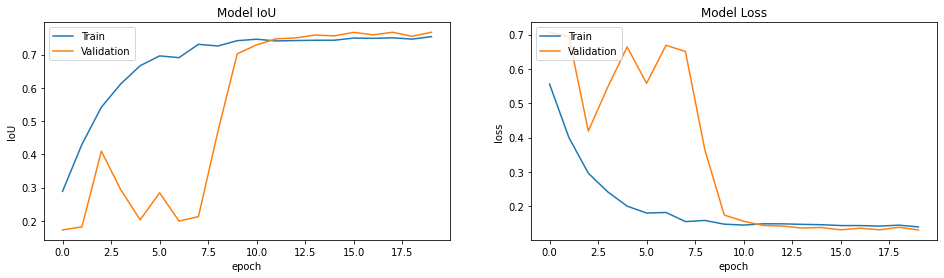

In [ ]:
plot_history(history)

# 模型評估

使用測試集來評估模型的訓練結果

In [ ]:
test_loss, test_iou = model.evaluate(test_x, test_y, batch_size=batch_size)
print("test loss:", test_loss)
print("test IoU:", test_iou)

1/1 [==============================] - 0s 157ms/step - loss: 0.2030 - iou_score: 0.6625
test loss: 0.20301640033721924
test IoU: 0.6624876856803894


# 模型預測

1/1 [==============================] - 0s 24ms/step


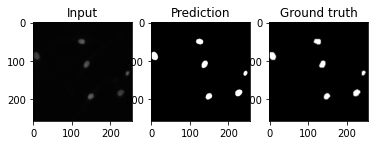

IoU:  0.84172565


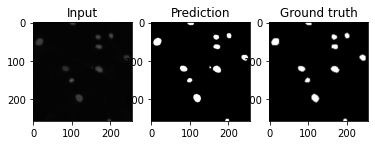

IoU:  0.8295399


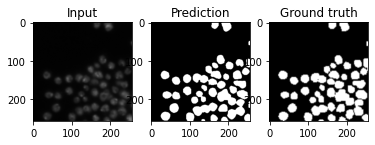

IoU:  0.8469088


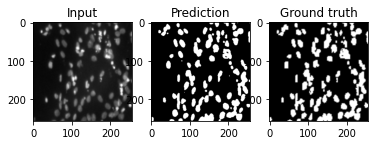

IoU:  0.7965071


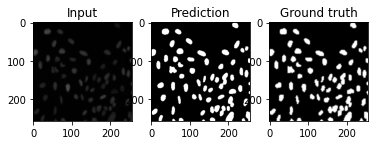

IoU:  0.7955888


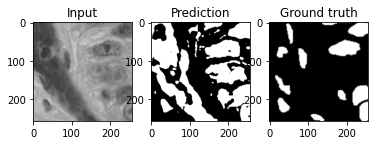

IoU:  0.4675657


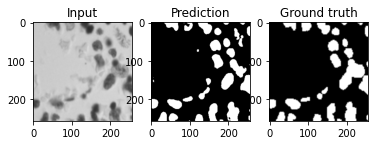

IoU:  0.83870107


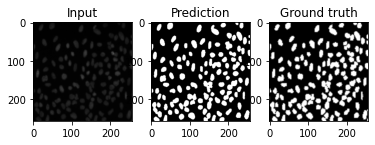

IoU:  0.76593554


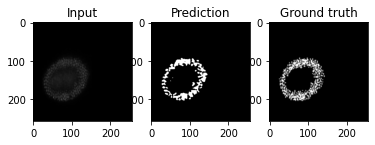

IoU:  0.5552239


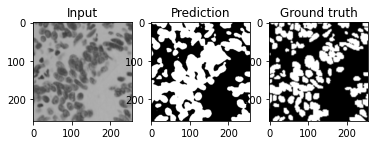

IoU:  0.6217365


In [ ]:
num=10
preds = model.predict(test_x[:num])
for i in range(num):
    _, axes = plt.subplots(1, 3, figsize=(6, 2))
    axes[0].set_title('Input')
    axes[0].imshow(test_x[:num][i].squeeze(), 'gray')
    
    pred_mask = preds[i]
    pred_mask[pred_mask > 0.5] = 1
    pred_mask[pred_mask <= 0.5] = 0
    _pred = pred_mask.squeeze()
    axes[1].set_title('Prediction')
    axes[1].imshow(_pred, cmap='gray')
    
    _gt = test_y[:num][i].squeeze()
    axes[2].set_title('Ground truth')
    axes[2].imshow(_gt, cmap='gray')
    plt.show()

    m = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0,1])
    m.reset_state()
    m.update_state(test_y[:num][i].squeeze(), pred_mask.squeeze())
    print("IoU: ", m.result().numpy())